In [ ]:
import pandas as pd
from lifelines import *
from lifelines.plotting import qq_plot
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("processed_data.csv")
df.head()

,Age,Weight (lbs),Gender,Ethnicity,Smoking status,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),...,EGFR mutation status,KRAS mutation status,ALK translocation status,Adjuvant Treatment,Chemotherapy,Radiation,Recurrence,Days between CT and surgery,Time to Event,Event
0,79,146.0,0,2,1,0,0,1,1,1,...,1,1,1,0,0,0,0,42,3078,0
1,65,195.0,0,1,2,0,0,1,1,1,...,1,1,1,0,0,0,0,23,70,0
2,65,173.5,1,2,0,0,1,1,1,1,...,0,0,2,0,0,0,0,25,666,0
3,67,173.5,1,2,1,0,1,1,1,0,...,2,2,2,1,1,1,1,89,1172,0
4,84,145.0,1,4,1,0,1,0,1,1,...,2,1,2,0,0,0,1,92,1456,1


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 144 total observations, 93 right-censored observations>
   number of observations = 144
number of events observed = 51
           log-likelihood = -469.89
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 4827.66   1094.87         2681.76         6973.56
rho_       0.79      0.10            0.59            0.98

         cmp to     z      p  -log2(p)
lambda_    1.00  4.41 <0.005     16.55
rho_       1.00 -2.15   0.03      5.00
---
AIC = 943.78

Text(0.5, 1.0, 'Cumulative hazard of Weibull model; estimated parameters')

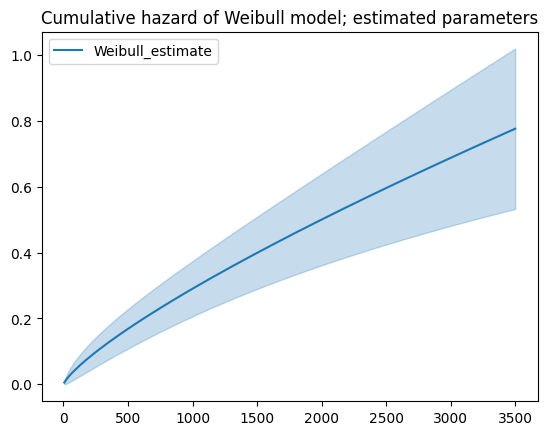

In [3]:
T = df['Time to Event']
E = df['Event']

wf = WeibullFitter().fit(T, E)

wf.print_summary()
ax = wf.plot_cumulative_hazard()
ax.set_title("Cumulative hazard of Weibull model; estimated parameters")

<Axes: xlabel='fitted loglogistic quantiles', ylabel='empirical quantiles'>

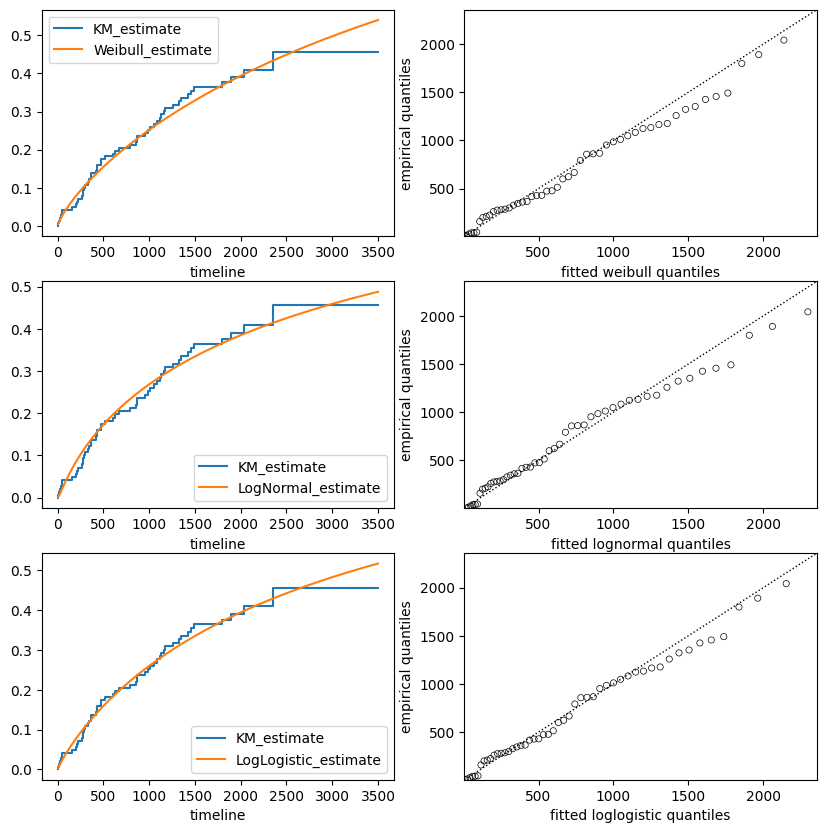

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

wf = WeibullFitter()
wf.fit(T, E)
lnf = LogNormalFitter()
lnf.fit(T, E)
lgf = LogLogisticFitter()
lgf.fit(T, E)

kmf = KaplanMeierFitter()
kmf.fit(T, E)

kmf.plot_cumulative_density(ax=axes[0][0], ci_show=False)
wf.plot_cumulative_density(ax=axes[0][0], ci_show=False)
qq_plot(wf, ax=axes[0][1])

kmf.plot_cumulative_density(ax=axes[1][0], ci_show=False)
lnf.plot_cumulative_density(ax=axes[1][0], ci_show=False)
qq_plot(lnf, ax=axes[1][1])

kmf.plot_cumulative_density(ax=axes[2][0], ci_show=False)
lgf.plot_cumulative_density(ax=axes[2][0], ci_show=False)
qq_plot(lgf, ax=axes[2][1])

In [ ]:
aic_scores = {
    'Weibull': wf.AIC_,
    'LogNormal': lnf.AIC_,
    'LogLogistic': lgf.AIC_
}
bic_scores = {
    'Weibull': wf.BIC_,
    'LogNormal': lnf.BIC_,
    'LogLogistic': lgf.BIC_
}
results = pd.DataFrame({
    'AIC': aic_scores,
    'BIC': bic_scores
})
results['Log-likelihood'] = {
    'Weibull': wf.log_likelihood_,
    'LogNormal': lnf.log_likelihood_,
    'LogLogistic': lgf.log_likelihood_
}

In [ ]:
results_sorted_by_aic = results.sort_values('AIC')
results_sorted_by_bic = results.sort_values('BIC')

print("Kết quả sắp xếp theo AIC (thấp hơn = tốt hơn):")
print(results_sorted_by_aic)

print("\nKết quả sắp xếp theo BIC (thấp hơn = tốt hơn):")
print(results_sorted_by_bic)

Kết quả sắp xếp theo AIC (thấp hơn = tốt hơn):
                    AIC         BIC  Log-likelihood
LogLogistic  943.091148  949.030774     -469.545574
Weibull      943.778103  949.717729     -469.889051
LogNormal    944.444482  950.384109     -470.222241

Kết quả sắp xếp theo BIC (thấp hơn = tốt hơn):
                    AIC         BIC  Log-likelihood
LogLogistic  943.091148  949.030774     -469.545574
Weibull      943.778103  949.717729     -469.889051
LogNormal    944.444482  950.384109     -470.222241


In [19]:
# Tính toán delta AIC và weights
min_aic = results['AIC'].min()
results['delta_AIC'] = results['AIC'] - min_aic
results['AIC_weight'] = np.exp(-0.5 * results['delta_AIC']) / sum(np.exp(-0.5 * results['delta_AIC']))

# Tính toán delta BIC
min_bic = results['BIC'].min()
results['delta_BIC'] = results['BIC'] - min_bic
results['BIC_weight'] = np.exp(-0.5 * results['delta_BIC']) / sum(np.exp(-0.5 * results['delta_BIC']))

print("\nPhân tích chi tiết:")
print(results[['AIC', 'delta_AIC', 'AIC_weight', 'BIC', 'delta_BIC', 'BIC_weight']])


Phân tích chi tiết:
                    AIC  delta_AIC  AIC_weight         BIC  delta_BIC  \
Weibull      943.778103   0.686955    0.319849  949.717729   0.686955   
LogNormal    944.444482   1.353334    0.229215  950.384109   1.353334   
LogLogistic  943.091148   0.000000    0.450936  949.030774   0.000000   

             BIC_weight  
Weibull        0.319849  
LogNormal      0.229215  
LogLogistic    0.450936  
